###NumtaDB Bangla handwritten Digits
Bengali Handwritten Digits recognization can be solved using many techniques.  I will use neural network for solving this problem
 
the main motive is to make the model recognize the hand written digit accurately.,changing the hyperparameter to see for which combination the accuracy is better.


**Numta DB** is a database.This database contains handwritten digits (0 through 9) in bengali, and can provide a baseline for testing image processing systems.


<div align="center">
<img src="https://drive.google.com/uc?id=1k5iKYOTrJmuSRPbWazZyBboaUPWabcmR" width="400">
</div>




**Importing all necessary library**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import os
from os import path
from torchvision import  models
import shutil
import matplotlib.pyplot as plt 

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saimom","key":"836f2f1447e07bed180067c9bd62a2ee"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


**importing numtaDB dataset from kaggle**

In [ ]:
!kaggle datasets download -d BengaliAI/numta -p /content/gdrive/My\ Drive/Softcom

100% 1.90G/1.91G [00:21<00:00, 84.2MB/s]
100% 1.91G/1.91G [00:21<00:00, 97.3MB/s]


**unzipping numta.zip dataset**

In [ ]:
from zipfile import ZipFile
file_name = "/content/gdrive/My Drive/Softcom/numta.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
from google.colab import drive #mounted all file and folder from google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**changing the directory**

In [ ]:
root_path = '/content/gdrive/My Drive/Softcom/'
Root = '/content/'
os.listdir(Root)

['.config',
 'training-c',
 'training-d',
 'training-c.csv',
 'testing-b',
 'testing-all-corrected',
 'training-a.csv',
 'testing-e',
 'testing-f',
 'training-e.csv',
 'gdrive',
 'testing-c',
 'kaggle.json',
 'testing-a',
 'testing-d',
 'training-a',
 'testing-augc',
 'training-b',
 'training-e',
 'training-b.csv',
 'training-d.csv',
 'testing-auga',
 'sample_data']

**Function for reading csv file**

In [ ]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(Root+csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

In [ ]:
a_csv = showRawTrainingSamples('training-a.csv')
b_csv = showRawTrainingSamples('training-b.csv')
c_csv = showRawTrainingSamples('training-c.csv')
d_csv = showRawTrainingSamples('training-d.csv')
e_csv = showRawTrainingSamples('training-e.csv')

training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-b.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-c.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-d.csv
Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')
training-e.csv
Index(['filename', 'original filename', 'districtid', 'institutionid',
       'gender', 'age', 'datestamp', 'scanid', 'digit',
       'database name original', 'database name'],
      dtype='object')


In [ ]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file)
  
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

In [ ]:
a_csv = dropColumns(a_csv)

         filename  digit
0      a00000.png      5
1      a00001.png      3
2      a00002.png      1
3      a00003.png      7
4      a00004.png      0
...           ...    ...
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8

[19702 rows x 2 columns]
     filename  digit
0  a00000.png      5
1  a00001.png      3
2  a00002.png      1
3  a00003.png      7
4  a00004.png      0


**Merging all csv file**

In [ ]:
total_csv = [a_csv,c_csv, d_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

54908


In [ ]:
TRAIN_PATH = 'train'
os.mkdir(TRAIN_PATH)


FileExistsError: ignored

**All images in one folder function**

In [ ]:
def processImages(folder_name):
  src = Root + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)  

In [ ]:
processImages('training-a')
print('A Done')
#processImages('training-b')
#print('B Done')
processImages('training-c')
print('C Done')
processImages('training-d')
print('D Done')
#processImages('training-e')
#print('E Done')


A Done
C Done
D Done


### Hyperparameter initialazation
Hyper parameter is predefined which is not changed during run time.But it is an important factor. we must be careful about choosing the hyperparameter value.
Here batch size,number of iteration,input dimension,output dimension,learning rate are Hyperparameters.Even choosing the optimizer is also a hyperparameter.we chose loss Entropy instead of MSE here for better output

In [ ]:
batch_size = 80
num_iters = 2000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 100
learning_rate = 0.1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Function for preparing Dataset**

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

**Resizing and normalizing  the trained and test images**

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])

train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
print(train_data[50])





**Showing Image**

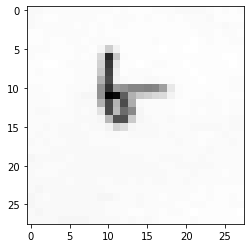

In [ ]:

show_img = train_data[250][0].numpy().reshape(28,28)
plt.imshow(show_img, cmap='gray')

In [ ]:
print(train_data[2052][0].numpy().shape)

(1, 28, 28)


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 80
  - Number of examples in **1** iteration

- **iterations:** 2000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 2000 \div \frac{54908}{80} = 2$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:618
Test dataloader:69


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=100, out_features=100, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

###Neural Network
A neural network is a network or circuit of neurons, or in a modern sense, an artificial neural network, composed of artificial neurons or nodes. Thus a neural network is either a biological neural network, made up of real biological neurons, or an artificial neural network, for solving artificial intelligence (AI) problems. The connections of the biological neuron are modeled as weights. A positive weight reflects an excitatory connection, while negative values mean inhibitory connections. All inputs are modified by a weight and summed. This activity is referred to as a linear combination. Finally, an activation function controls the amplitude of the output. For example, an acceptable range of output is usually between 0 and 1, or it could be −1 and 1. 

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

### Construct loss and optimizer (select from PyTorch API)

Unlike linear regression, we do not use MSE here, we need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax **([Logistic or Sigmoid]/softmax function)**
2. Computes Cross Entropy Loss

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training: forward, loss, backward, step

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2991738319396973. Accuracy: 10.564663023679417
Iteration: 1000. Loss: 2.2986435890197754. Accuracy: 13.66120218579235


**Setting 2**

In [ ]:
batch_size = 100
num_iters = 3000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 100
learning_rate = 0.1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 100
  - Number of examples in **1** iteration

- **iterations:** 3000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 3000 \div \frac{54908}{100} = 5$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:495
Test dataloader:55


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2383480072021484. Accuracy: 19.07103825136612
Iteration: 1000. Loss: 2.2387614250183105. Accuracy: 13.114754098360656
Iteration: 1500. Loss: 2.199225425720215. Accuracy: 10.236794171220401
Iteration: 2000. Loss: 2.2497000694274902. Accuracy: 13.242258652094717


**Setting3**

In [ ]:
batch_size = 100
num_iters = 3000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 100
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 100
  - Number of examples in **1** iteration

- **iterations:** 3000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 3000 \div \frac{54908}{100} = 5$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:495
Test dataloader:55


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Iteration: 500. Loss: 2.3070762157440186. Accuracy: 10.218579234972678
Iteration: 1000. Loss: 2.3027970790863037. Accuracy: 10.218579234972678
Iteration: 1500. Loss: 2.2985239028930664. Accuracy: 10.218579234972678
Iteration: 2000. Loss: 2.3015286922454834. Accuracy: 10.218579234972678


**Setting 4**

In [ ]:
batch_size = 100
num_iters = 6000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 100
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 100
  - Number of examples in **1** iteration

- **iterations:** 6000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 6000 \div \frac{54908}{100} = 10$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:495
Test dataloader:55


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))




Iteration: 500. Loss: 2.296241044998169. Accuracy: 10.473588342440802
Iteration: 1000. Loss: 2.294959306716919. Accuracy: 10.473588342440802
Iteration: 1500. Loss: 2.3031046390533447. Accuracy: 10.473588342440802
Iteration: 2000. Loss: 2.304809331893921. Accuracy: 10.309653916211293
Iteration: 2500. Loss: 2.300670862197876. Accuracy: 10.400728597449909
Iteration: 3000. Loss: 2.2974512577056885. Accuracy: 10.34608378870674
Iteration: 3500. Loss: 2.30478572845459. Accuracy: 9.70856102003643
Iteration: 4000. Loss: 2.301753520965576. Accuracy: 9.617486338797814
Iteration: 4500. Loss: 2.302274703979492. Accuracy: 9.562841530054644


**Setting 5**

In [ ]:
batch_size = 32
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 100
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 32
  - Number of examples in **1** iteration

- **iterations:** 5000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 5000 \div \frac{54908}{32} = 2$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:1545
Test dataloader:172


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))




Iteration: 500. Loss: 2.3004209995269775. Accuracy: 10.163934426229508
Iteration: 1000. Loss: 2.3158860206604004. Accuracy: 9.544626593806921
Iteration: 1500. Loss: 2.295912265777588. Accuracy: 9.781420765027322
Iteration: 2000. Loss: 2.305145263671875. Accuracy: 10.0
Iteration: 2500. Loss: 2.304875612258911. Accuracy: 10.145719489981785
Iteration: 3000. Loss: 2.298393487930298. Accuracy: 10.072859744990893


**Setting 6**


In [ ]:
batch_size = 200
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 100
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" +  item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.Scale(28,28),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        #transforms.Scale(28,28),
        transforms.ToTensor()
])




train_data  = Dataset(merged_csv,TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv,TRAIN_PATH, test_transform)


print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))
#print(train_data[50])





Trainig Samples:  54908
Test Samples:  54908


splitting the training set to **90%** and test set to **10%**. That means a **90:10** ratio. 
- **totaldata:** 54908
- **minibatch:** 200
  - Number of examples in **1** iteration

- **iterations:** 5000
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 5000 \div \frac{54908}{200} = 18$

In [ ]:
num_train = len(train_data)

# split data 10% for testing
test_size = 0.1

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler = train_idx
    )
#i faced the sampler and shuffle problem
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler = test_idx
    )

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))




Iteration: 500. Loss: 2.3004629611968994. Accuracy: 9.380692167577413
Iteration: 1000. Loss: 2.3115832805633545. Accuracy: 9.380692167577413
Iteration: 1500. Loss: 2.3055124282836914. Accuracy: 9.380692167577413
Iteration: 2000. Loss: 2.302356004714966. Accuracy: 9.380692167577413
Iteration: 2500. Loss: 2.3051397800445557. Accuracy: 9.380692167577413
Iteration: 3000. Loss: 2.3082175254821777. Accuracy: 9.380692167577413
Iteration: 3500. Loss: 2.3020873069763184. Accuracy: 9.380692167577413
Iteration: 4000. Loss: 2.3022334575653076. Accuracy: 9.380692167577413



###Result
|Setting| Batch Size       | No. of iteration     | Learning Rate     |
| :------------- | :----------: | -----------: |:------------- |
|           |
|1|  80 | 2000   | .1    |
|2| 100   | 3000 | .1|
|3| 100|3000 |.001 |
|4| 100|6000 |.001 |
|5|32|5000|.001|
|6|200|5000|.001|
|

In first setting batch size is 80, no. of iteration is 2000 and learning rate is .1 the accuracy is 13% .In setting 2 batch size was updated  others were remained same. accuracy increased a bit.accuracy was 19%.in setting 3 i kept batch size and  no. of iteration same and learning rate was changed from .1 to .001  still there is no improvement of the accuracy.accuracy was 10%.in setting 4 when i changed the no. of iteration from 3000 to 6000 and others were kept same accuracy was still 10%.in setting 5 and 6 batch size was decreased very less and after that setting batch size was increased very high. but there is no difference was visible in term of accuracy.

So,in my model higher no. of iteration and batch size is increasing the accuracy . 

